In [19]:
%%configure -f
{
    "conf":
    {
        "spark.driver.extraJavaOptions" : "--add-opens java.base/jdk.internal.loader=ALL-UNNAMED",
        "spark.jars.packages": "com.google.protobuf:protobuf-java:3.25.5"
    }
}

StatementMeta(, 278578ef-f5c2-44b8-a1c6-839d355b365d, -1, Finished, Available, Finished)

In [20]:
# Import the required geoanalytics_fabric modules
# ESRI - FABRIC reference: https://developers.arcgis.com/geoanalytics-fabric/

import geoanalytics_fabric
from geoanalytics_fabric.sql import functions as ST
from geoanalytics_fabric import extensions


StatementMeta(, 278578ef-f5c2-44b8-a1c6-839d355b365d, 5, Finished, Available, Finished)

In [21]:
# Get ROI based on BAG-woonplaats (=Loppersum)

# import required modules
from pyspark.sql.functions import col

# Read woonplaats data
path_woonplaats = "Files/BAG NL/BAG_woonplaats_202504.parquet"
df_woonplaats = spark.read.format("geoparquet").load(path_woonplaats)

# Filter the DataFrame where the "woonplaats" column contains the string "Loppersum"
df_loppersum = df_woonplaats.filter(col("woonplaats").contains("Loppersum"))

StatementMeta(, 278578ef-f5c2-44b8-a1c6-839d355b365d, 6, Finished, Available, Finished)

In [22]:
# Read building BAG data ROI

path_buildings = "Files/Results/Buildings/Loppersum/buildings_older_2009.parquet"
df_buildings = spark.read.format("geoparquet").load(path_buildings)

StatementMeta(, 278578ef-f5c2-44b8-a1c6-839d355b365d, 7, Finished, Available, Finished)

In [23]:
# Read building aggregrated/regressed data

path_buildings_reg = "Files/Results/Buildings/Loppersum/buildings_AHN3_regression.parquet"
df_buildings_reg = spark.read.format("geoparquet").load(path_buildings_reg)

StatementMeta(, 278578ef-f5c2-44b8-a1c6-839d355b365d, 8, Finished, Available, Finished)

StatementMeta(, 278578ef-f5c2-44b8-a1c6-839d355b365d, 11, Finished, Available, Finished)

<Axes: >

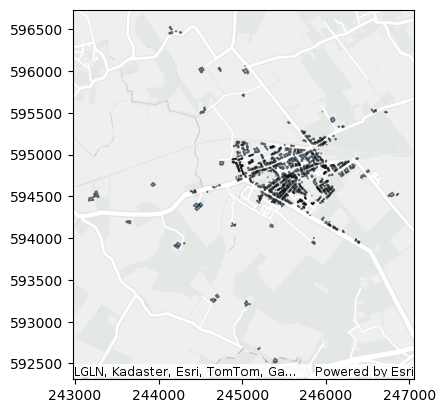

In [26]:
# visualize Loppersum buildings
df_buildings.st.plot(basemap="light", geometry="geometry", edgecolor="black", alpha=0.5) #  facecolor="yellow",

StatementMeta(, 44eba715-0df2-48af-9cd6-437028f2daa7, 10, Finished, Available, Finished)

<Axes: >

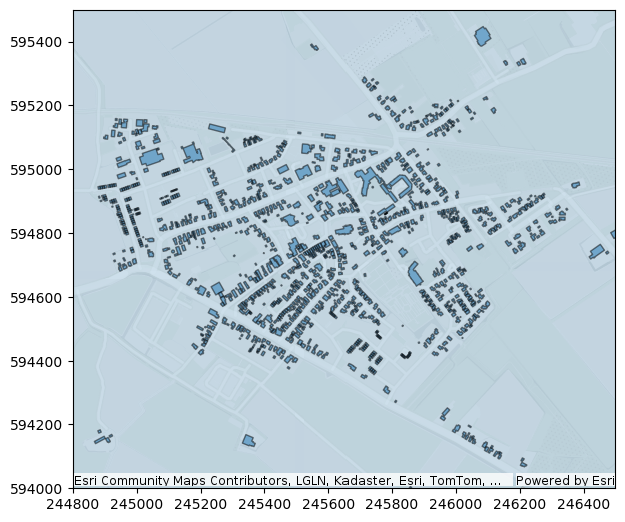

In [16]:
# Vizualize Loppersum area and buildings

axes = df_loppersum.st.plot(basemap="light", edgecolor="black", figsize=(7, 7), alpha=0.2)
axes.set(xlim=(244800, 246500), ylim=(594000, 595500))

df_buildings.st.plot(ax=axes, basemap="light", alpha=0.5, edgecolor="black") #, color='xkcd:sea blue'

In [27]:
df_buildings_reg.printSchema()

StatementMeta(, 278578ef-f5c2-44b8-a1c6-839d355b365d, 12, Finished, Available, Finished)

root
 |-- identificatie: string (nullable = true)
 |-- geometry: polygon (nullable = true)
 |-- centroid: point (nullable = true)
 |-- T1_z_mean: double (nullable = true)
 |-- T2_z_mean: double (nullable = true)
 |-- T3_z_mean: double (nullable = true)
 |-- PREDICTED_T3_z_mean: double (nullable = true)
 |-- Intercept: double (nullable = true)
 |-- SE_Intercept: double (nullable = true)
 |-- C_T1_z_mean: double (nullable = true)
 |-- SE_T1_z_mean: double (nullable = true)
 |-- C_T2_z_mean: double (nullable = true)
 |-- SE_T2_z_mean: double (nullable = true)
 |-- COND_ADJ: string (nullable = true)
 |-- NUM_NBRS: integer (nullable = true)
 |-- LOCALR2: double (nullable = true)



In [42]:

df_with_difference = df_buildings_reg.withColumn("difference_23yr", col("PREDICTED_T3_z_mean") - col("T1_z_mean"))
df_with_difference = df_with_difference.withColumn("subsidence_mm_per_yr", col("difference_23yr") / 0.023)
df_with_difference = df_with_difference.withColumn("dif_T3pred_T3", col("PREDICTED_T3_z_mean")*1000 - col("T3_z_mean")*1000)
display(df_with_difference)

StatementMeta(, 278578ef-f5c2-44b8-a1c6-839d355b365d, 27, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, e870b470-f9cd-470f-b588-3b13c7d3b8d7)

StatementMeta(, 278578ef-f5c2-44b8-a1c6-839d355b365d, 20, Finished, Available, Finished)

<Axes: >

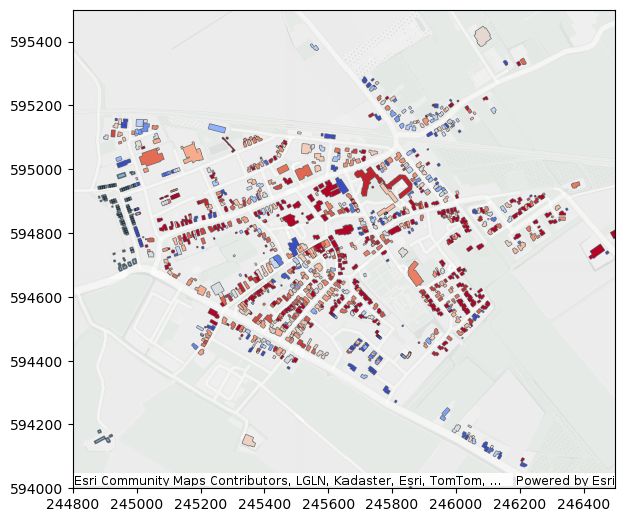

In [35]:
# Vizualize subsidence Loppersum area and buildings

axes = df_loppersum.st.plot(basemap="light", edgecolor="black", figsize=(7, 7), alpha=0)
axes.set(xlim=(244800, 246500), ylim=(594000, 595500))
df_buildings.st.plot(ax=axes, basemap="light", alpha=0.5, edgecolor="black") #, color='xkcd:sea blue'
df_with_difference.st.plot(ax=axes, basemap="light", cmap_values="subsidence_mm_per_yr", cmap="coolwarm_r", vmin=-10, vmax=10, geometry="geometry")


StatementMeta(, 278578ef-f5c2-44b8-a1c6-839d355b365d, 30, Finished, Available, Finished)

<Axes: >

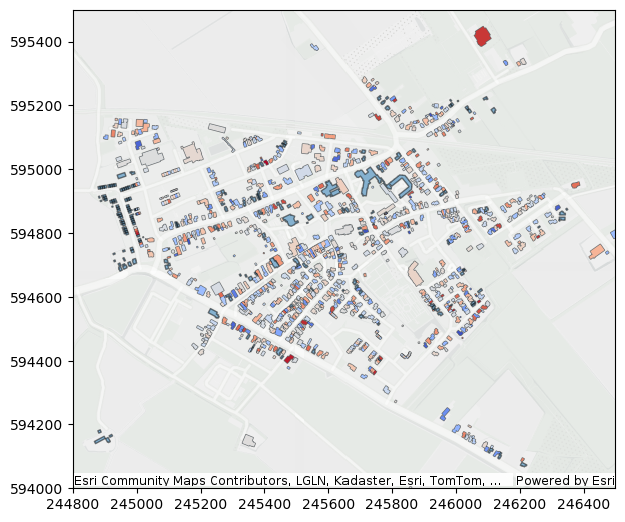

In [45]:
# Vizualize diff predictedAHN3-AHN3 Loppersum area and buildings


# Filter the DataFrame where the "woonplaats" column contains the string "Loppersum"
df_with_difference = df_with_difference.filter((df_with_difference.dif_T3pred_T3 > -150) & (df_with_difference.dif_T3pred_T3 < 150))

axes = df_loppersum.st.plot(basemap="light", edgecolor="black", figsize=(7, 7), alpha=0)
axes.set(xlim=(244800, 246500), ylim=(594000, 595500))
df_buildings.st.plot(ax=axes, basemap="light", alpha=0.5, edgecolor="black") #, color='xkcd:sea blue'
df_with_difference.st.plot(ax=axes, basemap="light", cmap_values="dif_T3pred_T3", cmap="coolwarm_r", vmin=-150, vmax=150, geometry="geometry")

In [46]:
display(df_with_difference)

StatementMeta(, 278578ef-f5c2-44b8-a1c6-839d355b365d, 31, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 8f1e4a55-8f20-431a-98f7-bbb988711aea)

In [47]:
df_with_difference.count()

StatementMeta(, 278578ef-f5c2-44b8-a1c6-839d355b365d, 32, Finished, Available, Finished)

984